
# Basic Statistics

This notebook implements the connected challenge set using monthly data from the Ken French Data Library:
- Fama–French 5 factors + Momentum (with risk-free)
- 25 Size×Book-to-Market portfolios

> Place CSVs under `data/` before running. See the README for details.

Goals:

1. Learn about the structure of jupyter notebooks.
2. Learn how to graphically present data.
3. Implement basic statistical functions in python by hand, e.g. normal distribution and bootstrapping.
4. Implement Statistical Hypothesis testing by hand and present it graphically.


Limitations:
1. Only permitted AI usage when importing the data.

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
from io import StringIO
import re

np.random.seed(42)
DATA_DIR = Path("Data") / "FRENCH"   # adjust if needed
test_path = DATA_DIR / "F-F_Research_Data_5_Factors_2x3.csv"
print("Looking for:", test_path.resolve())
print("Exists:", test_path.exists())
def _read_ff_monthly_table(path: Path) -> pd.DataFrame:
    """
    Robust Ken French monthly table reader:
    - Finds first data line by YYYYMM pattern.
    - Uses previous line as header if valid, else synthesizes sensible header.
    - Stops when monthly block ends (blank/notes/Annual).
    - Returns DataFrame with 'date' as month-end Timestamp.
    """
    txt = path.read_text(errors="ignore")
    lines = txt.splitlines()

    # Find first monthly data row (YYYYMM,...)
    yyyy_mm = re.compile(r"^\s*\d{6}\s*(,|\s)")
    first_data = None
    for i, ln in enumerate(lines):
        if yyyy_mm.match(ln):
            first_data = i
            break
    if first_data is None:
        raise ValueError(f"Could not find any YYYYMM monthly rows in {path.name}")

    # Candidate header = previous non-empty line
    header_idx = None
    for j in range(first_data - 1, -1, -1):
        if lines[j].strip() != "":
            header_idx = j
            break

    def looks_like_header(s: str) -> bool:
        return ("," in s) and (not yyyy_mm.match(s))

    data_block = []
    if header_idx is not None and looks_like_header(lines[header_idx]):
        data_block.append(lines[header_idx])
    else:
        # synthesize header based on number of columns
        n_cols = len(lines[first_data].split(","))
        if n_cols == 2:
            header = "date,Mom"
        elif n_cols == 7:
            header = "date,Mkt-RF,SMB,HML,RMW,CMA,RF"
        else:
            header = "date," + ",".join([f"col{k}" for k in range(1, n_cols)])
        data_block.append(header)

    # Append data rows until monthly block ends
    for ln in lines[first_data:]:
        s = ln.strip()
        if s == "" or s.lower().startswith("annual"):
            break
        if yyyy_mm.match(ln):
            data_block.append(ln)
        else:
            break

    df = pd.read_csv(StringIO("\n".join(data_block)))
    df.columns = [str(c).strip() for c in df.columns]
    first = df.columns[0]
    if first.lower() != "date":
        df = df.rename(columns={first: "date"})

    # Parse YYYYMM to month-end
    df["date"] = (
        pd.to_datetime(df["date"].astype(str).str.strip(), format="%Y%m")
          .dt.to_period("M").dt.to_timestamp("M")
    )
    return df

def load_ff_factors_monthly(data_dir: Path) -> pd.DataFrame:
    fac_path = data_dir / "F-F_Research_Data_5_Factors_2x3.csv"
    fac = _read_ff_monthly_table(fac_path)
    ren = {
        "Mkt-RF": "mktrf", "Mkt-Rf": "mktrf", "MKT-RF": "mktrf",
        "SMB": "smb", "HML": "hml", "RMW": "rmw", "CMA": "cma", "RF": "rf"
    }
    fac = fac.rename(columns=ren)
    for c in ["mktrf","smb","hml","rmw","cma","rf"]:
        fac[c] = fac[c].astype(float) / 100.0

    # Try optional momentum
    try:
        mom_path = data_dir / "F-F_Momentum_Factor.csv"
        mom = _read_ff_monthly_table(mom_path)
        mom_col = None
        for cand in mom.columns:
            if cand.strip().upper() in {"UMD", "MOM"}:
                mom_col = cand; break
        if mom_col:
            mom = mom.rename(columns={mom_col: "umd"})
            mom["umd"] = mom["umd"].astype(float) / 100.0
            fac = fac.merge(mom[["date","umd"]], on="date", how="left")
        else:
            fac["umd"] = np.nan
    except FileNotFoundError:
        fac["umd"] = np.nan

    return fac[["date","mktrf","smb","hml","rmw","cma","umd","rf"]]

def load_25_portfolios_monthly(data_dir: Path) -> pd.DataFrame:
    port_path = data_dir / "25_Portfolios_5x5.csv"
    wide = _read_ff_monthly_table(port_path)
    value_cols = [c for c in wide.columns if c != "date"]
    long = wide.melt(id_vars="date", value_vars=value_cols,
                     var_name="portfolio", value_name="ret")
    long["portfolio"] = long["portfolio"].astype(str).str.strip()
    long["ret"] = long["ret"].astype(float) / 100.0
    return long[["date","portfolio","ret"]]

def make_tidy(data_dir: Path) -> pd.DataFrame:
    fac = load_ff_factors_monthly(data_dir)
    ports = load_25_portfolios_monthly(data_dir)
    df = ports.merge(fac, on="date", how="inner")
    df["ret_excess"] = df["ret"] - df["rf"]
    return df

# Try it
df = make_tidy(DATA_DIR)
print(df.shape)
df.head()

Looking for: /Users/lassegrimmelt/PycharmProjects/PythonProject/Data/FRENCH/F-F_Research_Data_5_Factors_2x3.csv
Exists: True
(18600, 11)


,date,portfolio,ret,mktrf,smb,hml,rmw,cma,umd,rf,ret_excess
0,1963-07-31,SMALL LoBM,0.011286,-0.0039,-0.0048,-0.0081,0.0064,-0.0115,0.0101,0.0027,0.008586
1,1963-08-31,SMALL LoBM,0.042395,0.0508,-0.0080,0.0170,0.0040,-0.0038,0.0100,0.0025,0.039895
2,1963-09-30,SMALL LoBM,-0.017342,-0.0157,-0.0043,0.0000,-0.0078,0.0015,0.0012,0.0027,-0.020042
3,1963-10-31,SMALL LoBM,0.003778,0.0254,-0.0134,-0.0004,0.0279,-0.0225,0.0313,0.0029,0.000878
4,1963-11-30,SMALL LoBM,-0.033318,-0.0086,-0.0085,0.0173,-0.0043,0.0227,-0.0078,0.0027,-0.036018


## 0) Playground
We learn first basic commnds that we can do with this data frame. Note how the 'df' data frame is indexed by 0,1,..., whereas the wide_again frame is indexed by the date.


In [3]:
print([df.shape[0],df.shape[1]]) # Prints the column and row numbers

wide_again = df.pivot(index="date", columns="portfolio", values="ret_excess") #Create a new dataframe indexed by the data of the df, makes the portfolio element the columns and the ret value the value
print(wide_again.columns)
print(df.columns)
wide_again.head()


[18600, 11]
Index(['BIG HiBM', 'BIG LoBM', 'ME1 BM2', 'ME1 BM3', 'ME1 BM4', 'ME2 BM1',
       'ME2 BM2', 'ME2 BM3', 'ME2 BM4', 'ME2 BM5', 'ME3 BM1', 'ME3 BM2',
       'ME3 BM3', 'ME3 BM4', 'ME3 BM5', 'ME4 BM1', 'ME4 BM2', 'ME4 BM3',
       'ME4 BM4', 'ME4 BM5', 'ME5 BM2', 'ME5 BM3', 'ME5 BM4', 'SMALL HiBM',
       'SMALL LoBM'],
      dtype='object', name='portfolio')
Index(['date', 'portfolio', 'ret', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'umd',
       'rf', 'ret_excess'],
      dtype='object')


portfolio,BIG HiBM,BIG LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,ME5 BM2,ME5 BM3,ME5 BM4,SMALL HiBM,SMALL LoBM
date,,,,,,,,,,,,,,,,,,,,,
1963-07-31,-0.013744,-0.001309,-0.006332,0.004522,-0.003112,-0.020776,-0.000771,-0.012848,-0.022448,-0.014579,...,-0.011814,-0.020432,-0.021867,-0.018444,-0.021274,0.002138,0.008660,-0.006985,-0.015146,0.008586
1963-08-31,0.061484,0.055323,0.011230,0.012416,0.022568,0.053203,0.042719,0.041950,0.042161,0.079951,...,0.053254,0.044968,0.060016,0.074441,0.050956,0.040133,0.043841,0.079203,0.044143,0.039895
1963-09-30,-0.037733,-0.016451,0.003504,-0.012706,-0.017915,-0.043225,-0.017771,-0.011337,-0.017635,-0.031942,...,-0.029344,-0.024163,-0.020581,-0.042340,-0.022702,-0.010780,-0.011196,-0.004611,-0.006284,-0.020042
1963-10-31,0.001801,0.050360,-0.010228,0.010165,-0.000997,0.009025,0.039510,0.020626,0.020158,0.036413,...,-0.005315,0.004089,0.022313,0.045624,0.003238,0.014519,-0.006254,0.021275,0.020810,0.000878
1963-11-30,0.010795,-0.015369,-0.041136,-0.020593,-0.013234,-0.045296,-0.020184,-0.010544,-0.003253,-0.003850,...,-0.011782,-0.009011,-0.010216,0.010896,0.032706,0.007380,-0.019614,-0.024015,-0.013777,-0.036018


## Pre Cleaning

So, as we see we have in df a file in which portfolio is a column, or if we use the pivot code we have only the different portfolios in columns. Our first task is to create a new data frame that has all the columns and a unique date.



In [18]:

factors_unique = df.groupby("date")[["mktrf","smb","hml","rmw","cma","umd","rf"]].first()
factors_unique.head()
merged=pd.merge(wide_again, factors_unique, on="date", how="left")
merged.head()
print(merged.shape)

df=merged
print(df.columns)
df.head()

(744, 32)
Index(['BIG HiBM', 'BIG LoBM', 'ME1 BM2', 'ME1 BM3', 'ME1 BM4', 'ME2 BM1',
       'ME2 BM2', 'ME2 BM3', 'ME2 BM4', 'ME2 BM5', 'ME3 BM1', 'ME3 BM2',
       'ME3 BM3', 'ME3 BM4', 'ME3 BM5', 'ME4 BM1', 'ME4 BM2', 'ME4 BM3',
       'ME4 BM4', 'ME4 BM5', 'ME5 BM2', 'ME5 BM3', 'ME5 BM4', 'SMALL HiBM',
       'SMALL LoBM', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'umd', 'rf'],
      dtype='object')


,BIG HiBM,BIG LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME5 BM4,SMALL HiBM,SMALL LoBM,mktrf,smb,hml,rmw,cma,umd,rf
date,,,,,,,,,,,,,,,,,,,,,
1963-07-31,-0.013744,-0.001309,-0.006332,0.004522,-0.003112,-0.020776,-0.000771,-0.012848,-0.022448,-0.014579,...,-0.006985,-0.015146,0.008586,-0.0039,-0.0048,-0.0081,0.0064,-0.0115,0.0101,0.0027
1963-08-31,0.061484,0.055323,0.011230,0.012416,0.022568,0.053203,0.042719,0.041950,0.042161,0.079951,...,0.079203,0.044143,0.039895,0.0508,-0.0080,0.0170,0.0040,-0.0038,0.0100,0.0025
1963-09-30,-0.037733,-0.016451,0.003504,-0.012706,-0.017915,-0.043225,-0.017771,-0.011337,-0.017635,-0.031942,...,-0.004611,-0.006284,-0.020042,-0.0157,-0.0043,0.0000,-0.0078,0.0015,0.0012,0.0027
1963-10-31,0.001801,0.050360,-0.010228,0.010165,-0.000997,0.009025,0.039510,0.020626,0.020158,0.036413,...,0.021275,0.020810,0.000878,0.0254,-0.0134,-0.0004,0.0279,-0.0225,0.0313,0.0029
1963-11-30,0.010795,-0.015369,-0.041136,-0.020593,-0.013234,-0.045296,-0.020184,-0.010544,-0.003253,-0.003850,...,-0.024015,-0.013777,-0.036018,-0.0086,-0.0085,0.0173,-0.0043,0.0227,-0.0078,0.0027



## A) Visualiation

First goal is to visualise the some of portofolios excess returns.

We also calculate the Sample mean $\overline{X}_n=\frac{1}{n}\sum_{i\leq n}X_i$, both with in built function and by hand. Similar for the sample variance.

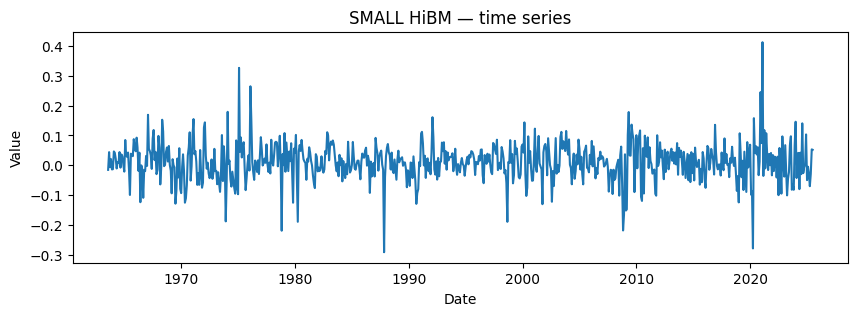

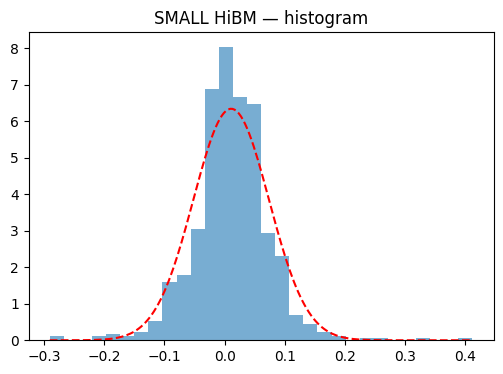

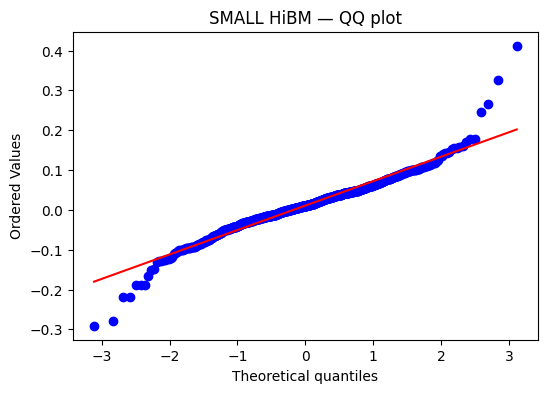

Some basic statistics
The calculated mean is 0.010853516129032258 The calculated standard deviation is 0.06293575832258669
I calculate the sample mean as 0.01085351612903227
I calculate the sample standard deviation as 0.06293575832258669


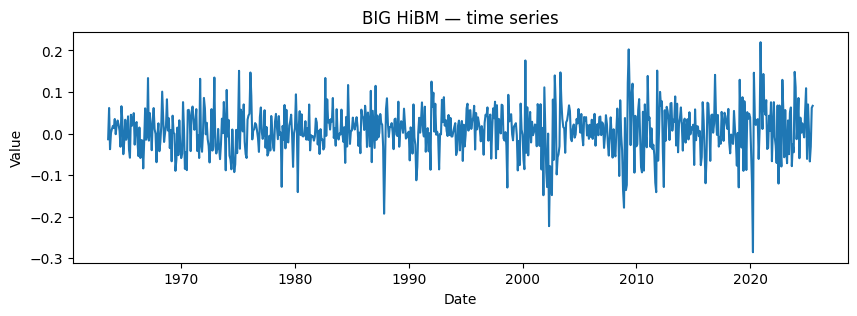

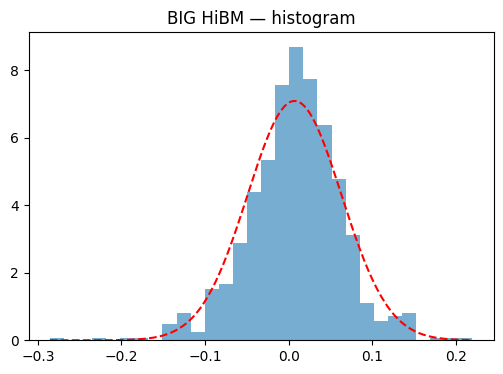

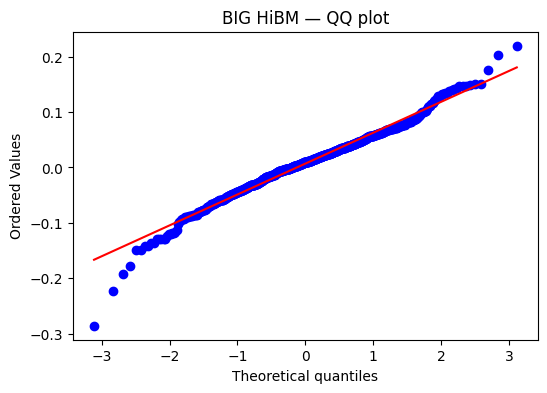

Some basic statistics
The calculated mean is 0.007023354838709677 The calculated standard deviation is 0.05625857677397292
I calculate the sample mean as 0.00702335483870968
I calculate the sample standard deviation as 0.05625857677397293


In [4]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import math


def sample_mean_manual(df):
    total=0.0
    count=0
    for j in df:
        total += j
        count += 1
    return total/count

def sample_sd_manual(df):
    svar=0.0
    count=0
    mean_manual=sample_mean_manual(df)
    for j in df:
        svar += (j-mean_manual)**2
        count += 1
    return math.sqrt(svar/(count-1))


def plot_column_distribution(df, column):
    x = df[column].dropna()

    # Time series (index on x-axis)
    plt.figure(figsize=(10,3))
    plt.plot(df.index, x)
    plt.title(f"{column} — time series")
    plt.xlabel(f"Date")
    plt.ylabel("Value")
    plt.show()

    # Histogram
    plt.figure(figsize=(6,4))
    plt.hist(x, bins=30, density=True, alpha=0.6)
    mu, sigma = x.mean(), x.std(ddof=1)
    xs = np.linspace(x.min(), x.max(), 200)
    plt.plot(xs, stats.norm.pdf(xs, mu, sigma), "r--")
    plt.title(f"{column} — histogram")
    plt.show()

    # QQ plot
    plt.figure(figsize=(6,4))
    stats.probplot(x, dist="norm", plot=plt)
    plt.title(f"{column} — QQ plot")
    plt.show()

    #Basic Stats
    print('Some basic statistics')
    print(f'The calculated mean is {x.mean()}', f'The calculated standard deviation is {x.std()}')



    print(f'I calculate the sample mean as {sample_mean_manual(df[column])}')
    print(f'I calculate the sample standard deviation as {sample_sd_manual(df[column])}')





plot_column_distribution(df, "SMALL HiBM")
plot_column_distribution(df, "BIG HiBM")

In both cases the distribution of values take a roughly normal shape. But it is standing out that the tails are heavier.

## B) Estimation & Confidence Intervals

Assuming (wrongly) that the data set consists of iid realisation of a random variable $X$ with finite variance, we next want to give 95% confidence intervals for the mean.

Approach 1: Using a $t$-interval. If the $X_i$ are i.i.d. by the CLT $\overline{X}_n \rightarrow N(\mu,\sigma^2/n)$. We plug in sample mean and sample variance (calulated above) and to get $95%$ sample interval via.

Approach 2: If $X$ is normal, then the $t_{n}$ distribution matches precisely the distribution of $\overline{X}_n$. In our case, since $n$ is large, the two results are virtually indistinguishable.

Approach 3: Quantile bootstrap


In [5]:
def mean_CI_Wald(df, confidence=0.95):
    mu_hat=sample_mean_manual(df)
    sigma_hat=sample_sd_manual(df)
    alpha=1-confidence
    tcrit=stats.norm.ppf(1-alpha/2)
    ci=(mu_hat-sigma_hat*tcrit/math.sqrt(len(df)),mu_hat+sigma_hat*tcrit/math.sqrt(len(df)))
    return ci

print(mean_CI_Wald(df["SMALL HiBM"]))

def mean_CI_t(df, confidence=0.95):
    mu_hat=sample_mean_manual(df)
    sigma_hat=sample_sd_manual(df)
    alpha=1-confidence
    tcrit = stats.t.ppf(1-alpha/2, df=len(df)-1)
    ci=(mu_hat-sigma_hat*tcrit/math.sqrt(len(df)),mu_hat+sigma_hat*tcrit/math.sqrt(len(df)))
    return ci

print(mean_CI_t(df["SMALL HiBM"]))

def mean_CI_quantboot(df, confidence=0.95, B=10000):
    n=len(df)
    alpha=1-confidence
    boots = np.empty(B, dtype=float) #Allocates a fixed block of B floats, more efficient than an array.
    for b in range(B):
        resample = np.random.choice(df, size=len(df), replace=True)
        boots[b]=sample_mean_manual(resample)
    ci=(np.quantile(boots, alpha/2), np.quantile(boots, 1-alpha/2))
    return ci

print(mean_CI_quantboot(df["SMALL HiBM"]))

def pick_block(df, b):
    n=len(df)
    j=np.random.randint(0, n-b+1)
    return df[j:j+b]

def move_block_boot(df, b):
    n=len(df)
    k=(n+b-1)//b
    if not (1 <= b <= n):
        raise ValueError("b must be in [1, n]")
    part=[pick_block(df, b) for _ in range(k)]
    return np.concatenate(part)[:n]

def mean_ci_quantshiftboot(df, confidence=0.95, B=1000, k=12): #Gives out the confidence interval with a shifting bootstrap approach
    alpha=1-confidence
    boots = np.empty(B, dtype=float) #Allocates a fixed block of floats.
    for b in range(B):
        resample = move_block_boot(df, k)
        boots[b]=sample_mean_manual(resample)
    ci=(np.quantile(boots, alpha/2), np.quantile(boots, 1-alpha/2))
    return ci

def mean_onesidedp_quantshiftboot(df, mu=0, B=1000, k=12):#Gives out the one sided p-value that mean>mu.
    n=len(df)
    boots = np.empty(B, dtype=float)
    for b in range(B):
        resample = move_block_boot(df, k)
        boots[b]=sample_mean_manual(resample)
    p = np.mean(boots >= mu)  #boots>= mu is an array of boolean, the mean corresponds to the percentage number of true values.
    return p


print(mean_onesidedp_quantshiftboot(df["SMALL HiBM"],0.004))



(np.float64(0.0063312190078827334), np.float64(0.015375813250181806))
(np.float64(0.006323840266841123), np.float64(0.015383191991223417))
(np.float64(0.006349586727150539), np.float64(0.015414857090053765))
0.991


## B+) Sanity Check

Let's take some existing implementations and compare our obtained confidence intervals.






In [6]:


from typing import Tuple


# t-based CI for mean
def ci_mean_t(x: np.ndarray, alpha: float=0.05) -> Tuple[float,float]:
    x = np.asarray(x)
    n = x.size
    m = x.mean()
    s = x.std(ddof=1)
    tcrit = stats.t.ppf(1 - alpha/2, df=n-1)
    half = tcrit * s/np.sqrt(n)
    return (m - half, m + half)

# IID bootstrap percentile CI for mean
def bootstrap_ci_mean(x: np.ndarray, alpha: float=0.05, B: int=10000) -> Tuple[float,float]:
    x = np.asarray(x)
    n = x.size
    boots = np.empty(B)
    for b in range(B):
        idx = np.random.randint(0, n, size=n)
        boots[b] = x[idx].mean()
    return (np.quantile(boots, alpha/2), np.quantile(boots, 1-alpha/2))

# Moving block bootstrap
def moving_block_bootstrap_ci_mean(x: np.ndarray, b: int=6, alpha: float=0.05, B: int=5000) -> Tuple[float,float]:
    x = np.asarray(x)
    n = x.size
    if b <= 0 or b > n:
        raise ValueError("Block length b must be in [1, n]")
    # Create overlapping blocks
    blocks = np.array([x[i:i+b] for i in range(n - b + 1)], dtype=object)
    means = np.empty(B)
    # Number of blocks to sample per bootstrap series
    k = int(np.ceil(n / b))
    for t in range(B):
        samp = []
        for _ in range(k):
            j = np.random.randint(0, len(blocks))
            samp.extend(blocks[j])
        samp = np.asarray(samp[:n])
        means[t] = samp.mean()
    return (np.quantile(means, alpha/2), np.quantile(means, 1-alpha/2))










print(ci_mean_t(df["SMALL HiBM"]))
print(bootstrap_ci_mean(df["SMALL HiBM"]))
print(moving_block_bootstrap_ci_mean(df["SMALL HiBM"]))

(np.float64(0.006323840266841111), np.float64(0.015383191991223405))
(np.float64(0.006323768649193549), np.float64(0.015370566196236559))
(np.float64(0.005605665154569892), np.float64(0.016247740120967743))


## C) Multiple Testing across 25 portfolios

We next do a hypothesis test: H0: $\mu_i \leq 0$ vs H1: $\mu_i > 0$

Note that strictly speaking, we are considering two sided 95% confidence intervals. This increase our type error. If we assume symmetric distribution, we in reality check with $p=0.0025$.

For Bonferri adjustment of preventing false posities, we instead consider $(100-5/25)%$ confidence, drastically decreasing the power of the result.



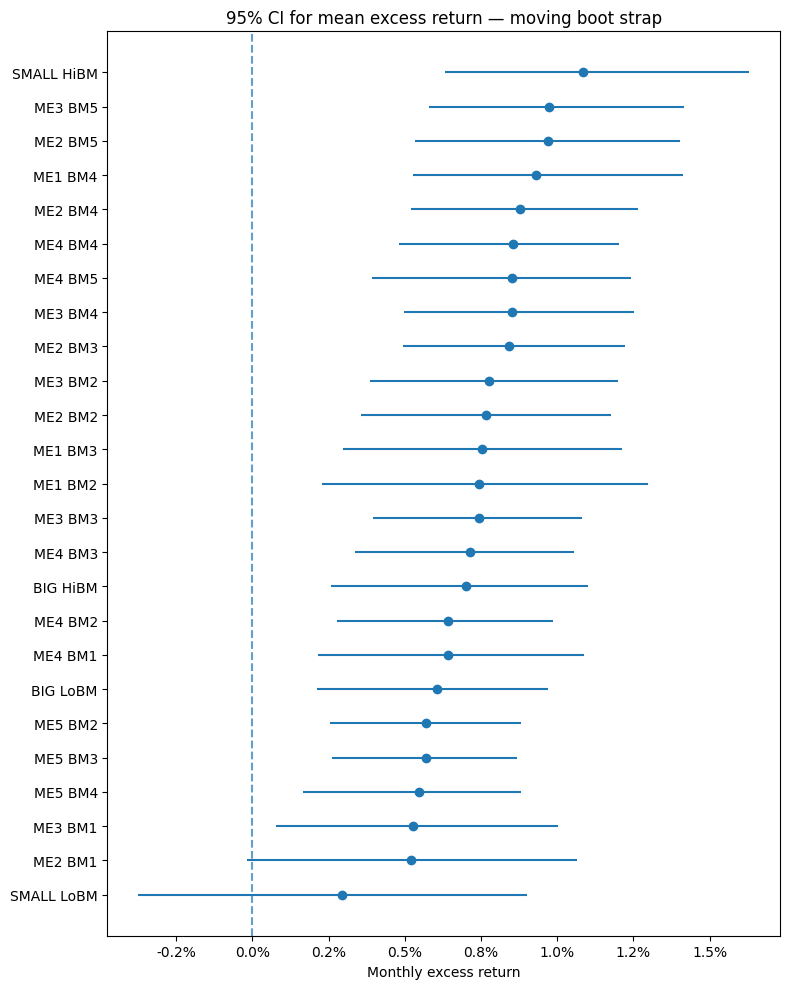

In [7]:

rows=[]
for portfolio in df.columns[0:25]:
    m=sample_mean_manual(df[portfolio])
    lo,hi=mean_ci_quantshiftboot(df[portfolio],0.95)
    rows.append((portfolio,m,lo,hi))

res = pd.DataFrame(rows, columns=['portfolio','mean','lo','hi']).sort_values('mean')

y = np.arange(len(res))
plt.figure(figsize=(8, 10))
plt.hlines(y, res['lo'], res['hi'])
plt.plot(res['mean'], y, 'o')
plt.axvline(0.0, ls='--', alpha=0.7)
plt.yticks(y, res['portfolio'])
plt.xlabel('Monthly excess return')
plt.title(f"95% CI for mean excess return — moving boot strap")
from matplotlib.ticker import FuncFormatter
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x*100:.1f}%"))

plt.tight_layout()
plt.show()








We next implement a Bonferri-Holm adjusted test.

In [51]:


def plist(df, mu=0):
    pvalue=[]
    for portfolio in df.columns[0:25]:
        p=1-mean_onesidedp_quantshiftboot(df[portfolio],mu)
        pvalue.append((portfolio,p))
    pframe=pd.DataFrame(pvalue, columns=['portfolio','pvalue']).sort_values('pvalue')
    return pframe



plist0=plist(df)
print(plist0)

     portfolio  pvalue
12     ME3 BM3   0.000
1     BIG LoBM   0.000
2      ME1 BM2   0.000
21     ME5 BM3   0.000
4      ME1 BM4   0.000
20     ME5 BM2   0.000
19     ME4 BM5   0.000
7      ME2 BM3   0.000
8      ME2 BM4   0.000
9      ME2 BM5   0.000
18     ME4 BM4   0.000
11     ME3 BM2   0.000
23  SMALL HiBM   0.000
13     ME3 BM4   0.000
14     ME3 BM5   0.000
17     ME4 BM3   0.000
0     BIG HiBM   0.001
6      ME2 BM2   0.001
3      ME1 BM3   0.001
16     ME4 BM2   0.001
15     ME4 BM1   0.004
22     ME5 BM4   0.004
10     ME3 BM1   0.009
5      ME2 BM1   0.019
24  SMALL LoBM   0.190


In [54]:

def bonferri_holm(plist, alpha=.05):
    n=len(plist)
    out = plist.copy().reset_index(drop=True)
    adj = []
    for i, p in enumerate(out["pvalue"], start=1):
        adj.append(min(1.0, (n - i + 1) * p))
    out["p_adj"] = adj
    for i in range(1, n):
        if out.loc[i, "p_adj"] < out.loc[i-1, "p_adj"]:
            out.loc[i, "p_adj"] = out.loc[i-1, "p_adj"]

    # reject if adjusted p < alpha
    out["reject"] = out["p_adj"] < alpha
    return out

print(bonferri_holm(plist0))

def benjamin_hochberg(plist, alpha=0.05):
    n=len(plist)
    out = plist.copy().reset_index(drop=True)
    adj=[]
    for i in range(0, n):
        adj.append((i+1)*alpha/n)
    out["bh-value"]=adj
    out["reject"] = out["pvalue"] < out["bh-value"]
    return out

print(benjamin_hochberg(plist0))


     portfolio  pvalue  p_adj  reject
0      ME3 BM3   0.000  0.000    True
1     BIG LoBM   0.000  0.000    True
2      ME1 BM2   0.000  0.000    True
3      ME5 BM3   0.000  0.000    True
4      ME1 BM4   0.000  0.000    True
5      ME5 BM2   0.000  0.000    True
6      ME4 BM5   0.000  0.000    True
7      ME2 BM3   0.000  0.000    True
8      ME2 BM4   0.000  0.000    True
9      ME2 BM5   0.000  0.000    True
10     ME4 BM4   0.000  0.000    True
11     ME3 BM2   0.000  0.000    True
12  SMALL HiBM   0.000  0.000    True
13     ME3 BM4   0.000  0.000    True
14     ME3 BM5   0.000  0.000    True
15     ME4 BM3   0.000  0.000    True
16    BIG HiBM   0.001  0.009    True
17     ME2 BM2   0.001  0.009    True
18     ME1 BM3   0.001  0.009    True
19     ME4 BM2   0.001  0.009    True
20     ME4 BM1   0.004  0.020    True
21     ME5 BM4   0.004  0.020    True
22     ME3 BM1   0.009  0.027    True
23     ME2 BM1   0.019  0.038    True
24  SMALL LoBM   0.190  0.190   False
     portfol

In [ ]:

def one_sided_t_pvalue_greater(x: np.ndarray, mu0: float=0.0) -> float:
    x = np.asarray(x)
    n = x.size
    m = x.mean()
    s = x.std(ddof=1)
    tstat = (m - mu0) / (s/np.sqrt(n))
    return 1 - stats.t.cdf(tstat, df=n-1)

def bonferroni_adjust(pvals: np.ndarray) -> np.ndarray:
    pvals = np.asarray(pvals)
    return np.minimum(1.0, pvals * pvals.size)

def holm_adjust(pvals: np.ndarray) -> np.ndarray:
    p = np.asarray(pvals)
    m = p.size
    order = np.argsort(p)
    adj = np.empty_like(p)
    for i, idx in enumerate(order):
        adj[idx] = min((m - i) * p[idx], 1.0)
    # enforce monotonicity
    for i in range(m-1):
        adj[order[i+1]] = max(adj[order[i+1]], adj[order[i]])
    return adj

def bh_fdr(pvals: np.ndarray, alpha: float=0.05):
    p = np.asarray(pvals)
    m = p.size
    order = np.argsort(p)
    ranked = p[order]
    thresh = (np.arange(1, m+1) / m) * alpha
    k = np.where(ranked <= thresh)[0].max() + 1 if np.any(ranked <= thresh) else 0
    rejected = np.zeros(m, dtype=bool)
    if k > 0:
        rejected[order[:k]] = True
    # BH-adjusted p-values
    adj = (m / np.arange(1, m+1)) * ranked
    # enforce monotone decreasing in reverse order
    adj = np.minimum.accumulate(adj[::-1])[::-1]
    out = np.empty_like(p)
    out[order] = np.clip(adj, 0, 1)
    return rejected, out




## D) Sharpe ratio inference

We follow the outline in : https://www.twosigma.com/wp-content/uploads/sharpe-tr-1.pdf and define the sharpe ratio of the portfolio p w.r.t to the risk free portfolio as $$\zeta_p=\frac{\mathbb{E}[R_p]}{\sqrt{Var[R_p]}}$$

With $\hat{\mu}$ and $\hat{\sigma}$ being the sample mean and sample standard deviation, define the basic estimator $$\hat{\zeta}_{\textup{basic}}=\frac{\hat{\mu}}{\hat{\sigma}}.$$




sharpe of BIG HiBM is 0.12484060638304158
sharpe of BIG LoBM is 0.1289627684971492
sharpe of ME1 BM2 is 0.10677022319029258
sharpe of ME1 BM3 is 0.12366005350028005
sharpe of ME1 BM4 is 0.1586664482462466
sharpe of ME2 BM1 is 0.07252235288881338
sharpe of ME2 BM2 is 0.12581809448217926
sharpe of ME2 BM3 is 0.15098300596824094
sharpe of ME2 BM4 is 0.1624515768617975
sharpe of ME2 BM5 is 0.15526161077084544
sharpe of ME3 BM1 is 0.08040815977771057
sharpe of ME3 BM2 is 0.14018767558305045
sharpe of ME3 BM3 is 0.14559167869533657
sharpe of ME3 BM4 is 0.16472113441608635
sharpe of ME3 BM5 is 0.16421991634819413
sharpe of ME4 BM1 is 0.11049918977597756
sharpe of ME4 BM2 is 0.12452284454120127
sharpe of ME4 BM3 is 0.14284695722265772
sharpe of ME4 BM4 is 0.1691690742514008
sharpe of ME4 BM5 is 0.14598147318725718
sharpe of ME5 BM2 is 0.12890769186211593
sharpe of ME5 BM3 is 0.13091834414531608
sharpe of ME5 BM4 is 0.11509061131504654
sharpe of SMALL HiBM is 0.17245388660292202
sharpe of SMALL

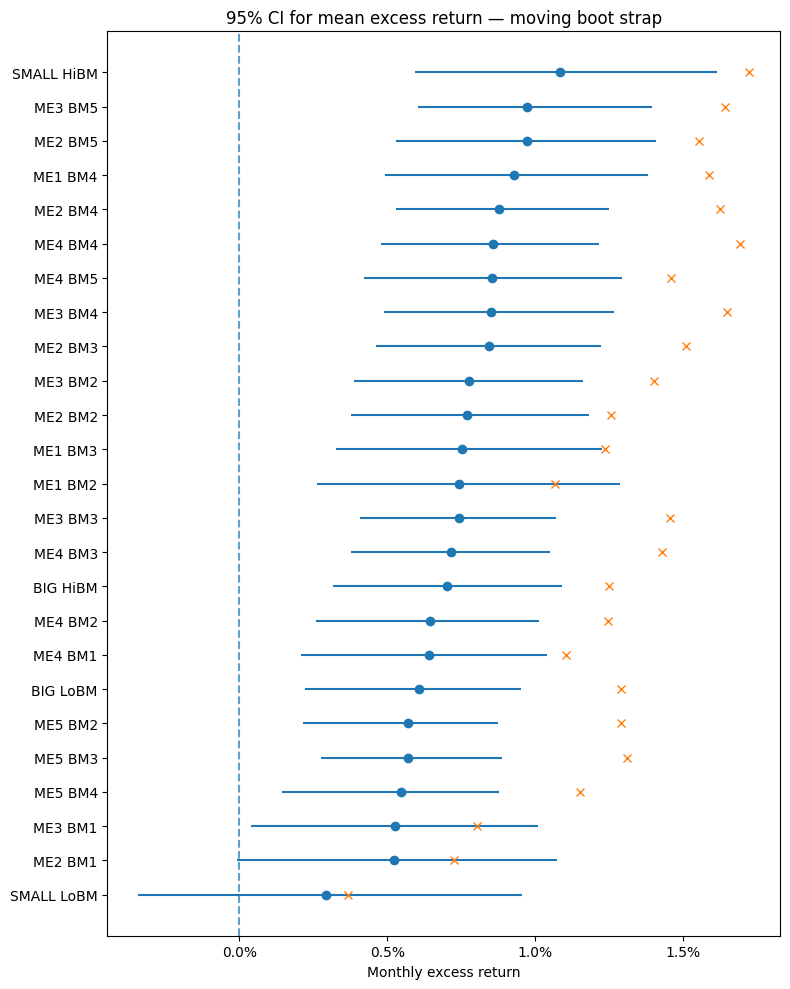

In [12]:


def sharp_basic(df):
    mu_hat=sample_mean_manual(df)
    sigma_hat=sample_sd_manual(df)
    return mu_hat/sigma_hat



for portfolio in df.columns[0:25]:
    print(f"sharpe of {portfolio} is {sharp_basic(df[portfolio])}")

rows=[]
for portfolio in df.columns[0:25]:
    m=sample_mean_manual(df[portfolio])
    lo,hi=mean_ci_quantshiftboot(df[portfolio],0.95)
    sharp=sharp_basic(df[portfolio])
    rows.append((portfolio,m,lo,hi,sharp))

res = pd.DataFrame(rows, columns=['portfolio','mean','lo','hi','sharp']).sort_values('mean')

y = np.arange(len(res))
plt.figure(figsize=(8, 10))
plt.hlines(y, res['lo'], res['hi'])
plt.plot(res['mean'], y, 'o')
plt.plot(res['sharp']/10,y, 'x')
plt.axvline(0.0, ls='--', alpha=0.7)
plt.yticks(y, res['portfolio'])
plt.xlabel('Monthly excess return')
plt.title(f"95% CI for mean excess return — moving boot strap")
from matplotlib.ticker import FuncFormatter
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x*100:.1f}%"))

plt.tight_layout()
plt.show()





In [56]:

def annualize_mean_std(mu_m: float, sd_m: float, periods: int=12) -> Tuple[float,float]:
    mu_a = periods * mu_m
    sd_a = (periods**0.5) * sd_m
    return mu_a, sd_a

def sharpe_ratio(x: np.ndarray) -> float:
    x = np.asarray(x)
    return x.mean() / x.std(ddof=1)

def sharpe_delta_ci(x: np.ndarray, alpha: float=0.05) -> Tuple[float,float]:
    x = np.asarray(x)
    n = x.size
    m = x.mean()
    s = x.std(ddof=1)
    S = m/s
    # Delta method variance of mean/sd (approx); uses Normal assumption
    # Var(S) ≈ (1/n) * (1 + 0.5*S**2)
    var_S = (1/n) * (1 + 0.5*(S**2))
    z = stats.norm.ppf(1 - alpha/2)
    return (S - z*np.sqrt(var_S), S + z*np.sqrt(var_S))

def bootstrap_sharpe_ci(x: np.ndarray, alpha: float=0.05, B: int=10000) -> Tuple[float,float]:
    x = np.asarray(x)
    n = x.size
    boots = np.empty(B)
    for b in range(B):
        idx = np.random.randint(0, n, size=n)
        xx = x[idx]
        boots[b] = xx.mean()/xx.std(ddof=1)
    return (np.quantile(boots, alpha/2), np.quantile(boots, 1-alpha/2))


## E) Structural breaks

In [24]:

def date_variation(df, cdate):
    cutoff=pd.Timestamp(cdate)
    totalbefore=0.0
    totalafter=0.0
    countbefore=0
    countafter=0
    for idx, val in df.items():
        if idx < cutoff:
            totalbefore=totalbefore+val
            countbefore=countbefore+1
        else:
            totalafter=totalafter+val
            countafter=countafter+1
    return totalbefore/countbefore, totalafter/countafter

print(date_variation(df["SMALL HiBM"], '1990-01-01'))




def sample_sd_manual(df):
    svar=0.0
    count=0
    mean_manual=sample_mean_manual(df)
    for j in df:
        svar += (j-mean_manual)**2
        count += 1
    return math.sqrt(svar/(count-1))














(0.010937144654088059, 0.01079108920187793)


In [ ]:


def two_sample_t_test(x: np.ndarray, y: np.ndarray, equal_var: bool=False):
    return stats.ttest_ind(x, y, equal_var=equal_var, alternative='two-sided')

# For variance equality, consider Levene's/Brown–Forsythe via scipy or implement manually.


## F) Likelihood modeling & LR tests

In [ ]:

from scipy.optimize import minimize
import numpy as np
from scipy import stats

def mle_normal(x: np.ndarray):
    x = np.asarray(x)
    def nll(params):
        mu, log_sigma = params
        sigma = np.exp(log_sigma)
        return 0.5*np.sum(((x - mu)/sigma)**2 + 2*log_sigma + np.log(2*np.pi))
    res = minimize(nll, x0=[x.mean(), np.log(x.std(ddof=1))], method='L-BFGS-B')
    mu, log_sigma = res.x
    return {"mu": mu, "sigma": np.exp(log_sigma), "success": res.success}

def mle_student_t(x: np.ndarray):
    x = np.asarray(x)
    def nll(params):
        mu, log_sigma, log_nu = params
        sigma = np.exp(log_sigma)
        nu = np.exp(log_nu) + 2.0  # ensure nu > 2
        z = (x - mu)/sigma
        return -np.sum(stats.t.logpdf(z, df=nu)) + x.size*np.log(sigma)
    res = minimize(nll, x0=[x.mean(), np.log(x.std(ddof=1)), np.log(10.0)], method='L-BFGS-B')
    mu, log_sigma, log_nu = res.x
    return {"mu": mu, "sigma": np.exp(log_sigma), "nu": np.exp(log_nu)+2.0, "success": res.success}

def lr_test_normal_vs_t(x: np.ndarray, B: int=2000, random_state: int=42):
    """Parametric bootstrap LR test: H0 Normal vs H1 Student-t."""
    rng = np.random.default_rng(random_state)
    fit0 = mle_normal(x)
    fit1 = mle_student_t(x)
    # LR stat observed
    def nll_norm(mu, sigma):
        return 0.5*np.sum(((x - mu)/sigma)**2 + 2*np.log(sigma) + np.log(2*np.pi))
    def nll_t(mu, sigma, nu):
        z = (x - mu)/sigma
        return -np.sum(stats.t.logpdf(z, df=nu)) + x.size*np.log(sigma)
    lr_obs = 2*(nll_norm(fit0["mu"], fit0["sigma"]) - nll_t(fit1["mu"], fit1["sigma"], fit1["nu"]))

    # Bootstrap under H0
    mu0, sd0 = fit0["mu"], fit0["sigma"]
    lr_boot = np.empty(B)
    for b in range(B):
        xb = rng.normal(mu0, sd0, size=x.size)
        f0b = mle_normal(xb)
        f1b = mle_student_t(xb)
        lr_boot[b] = 2*(nll_norm(f0b["mu"], f0b["sigma"]) - nll_t(f1b["mu"], f1b["sigma"], f1b["nu"]))
    pval = (np.sum(lr_boot >= lr_obs) + 1) / (B + 1)
    return lr_obs, pval


## G) Power & sample size

In [ ]:

from scipy import stats
import numpy as np

def required_months_for_power(mu_a: float, sd_a: float, target_alpha: float=0.05, target_power: float=0.8) -> int:
    """One-sided test for mean > 0. Convert annualized inputs to monthly, assume Normal iid."""
    mu_m = mu_a/12.0
    sd_m = sd_a/(12.0**0.5)
    n = 12
    z_alpha = stats.norm.ppf(1 - target_alpha)
    while True:
        se = sd_m / np.sqrt(n)
        # Normal-approx power
        z = mu_m / se
        power = 1 - stats.norm.cdf(z_alpha - z)
        if power >= target_power:
            return n
        n += 1

def simulate_power(mu_m: float, sd_m: float, n: int, trials: int=10000, alpha: float=0.05) -> float:
    rng = np.random.default_rng(42)
    rejections = 0
    for _ in range(trials):
        x = rng.normal(mu_m, sd_m, size=n)
        res = stats.ttest_1samp(x, popmean=0.0, alternative='greater')
        if res.pvalue < alpha:
            rejections += 1
    return rejections / trials
